In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import sqlalchemy as sa



In [2]:
#pulling in data from EW database and writing to file only need to run this once
#engine = sa.create_engine(os.environ["EW_CONNECT"])
sql = """
select 
    player
    ,player_upper
    ,api_id::integer
    ,birthday
    ,season_age
    ,position
    ,position_type
    ,shoots
    ,team
    ,season
    ,session
    ,gp
    ,toi
    ,toi_gp
    ,toi_perc
    ,g
    ,a1
    ,a2
    ,points
from skater_std_sum_all
where session = 'R'
"""
#nhl_df = pd.read_sql(sql, engine)
#nhl_df.to_csv('player_goal_data.csv')

In [5]:
nhl_df = pd.read_csv('player_goal_data.csv')
#convert season to integers
nhl_df.season = nhl_df.season.astype(int)
#create a column to join on to get the next season
nhl_df['season_minus_one'] = nhl_df['season'] - 10001
nhl_df = nhl_df.groupby(['player', 'api_id', 'season', 'season_minus_one', 'position_type'])['g'].sum().reset_index()

In [6]:
#create dataframe of season to season goal correlation
new_df = nhl_df[['player', 'api_id', 'g', 'season', 'season_minus_one', 'position_type']].merge(
        nhl_df[['player', 'api_id', 'g', 'season', 'season_minus_one', 'position_type']], how='inner',
        left_on=['api_id', 'season'], right_on=['api_id', 'season_minus_one'])

#create dataframe for forwards only
forwards_df = new_df[new_df.position_type_x == 'F']
#create dataframe for defense only
defense_df = new_df[new_df.position_type_x == 'D']

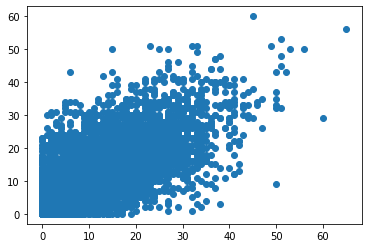

In [7]:
#total scatter correlation
#this is the test of linearity
plt.scatter(new_df[['g_x']], new_df[['g_y']])

In [11]:
#pearson correlation coefficients
forward_corr = forwards_df['g_x'].corr(forwards_df['g_y'])
def_corr = defense_df['g_x'].corr(defense_df['g_y'])
total_corr = new_df['g_x'].corr(new_df['g_y'])
print((f"Foward pearson R: {round(forward_corr, 2)}\n"
       f"Defense pearson R: {round(def_corr, 2)}\n"
       f"All Position Pearson R: {round(total_corr, 2)}"))

(array([3.379e+03, 1.316e+03, 9.360e+02, 6.880e+02, 7.750e+02, 4.030e+02,
        3.390e+02, 2.610e+02, 2.510e+02, 1.210e+02, 8.200e+01, 3.900e+01,
        4.300e+01, 1.400e+01, 4.000e+00, 1.100e+01, 2.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([ 0.  ,  3.25,  6.5 ,  9.75, 13.  , 16.25, 19.5 , 22.75, 26.  ,
        29.25, 32.5 , 35.75, 39.  , 42.25, 45.5 , 48.75, 52.  , 55.25,
        58.5 , 61.75, 65.  ]),
 <BarContainer object of 20 artists>)

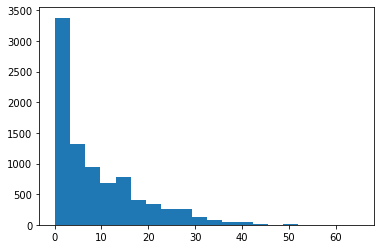

In [19]:
#Distribution of the data fits a poisson or pareto distribution
#this may be useful for more advanced models
plt.hist(new_df.g_x, bins=20)

In [22]:
#create a baseline linear model using previous season goals to predict next season
#goals

from sklearn.model_selection import train_test_split

#create test and train dataframes
train_df, test_df = train_test_split(new_df, test_size=0.2, random_state=8675309)



In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score

n_estimators = 5000
reg = BaggingRegressor(LinearRegression(), n_estimators=n_estimators, bootstrap=True)

reg.fit(train_df[['g_x']], train_df[['g_y']].values[:,0])

BaggingRegressor(base_estimator=LinearRegression(), n_estimators=5000)

In [86]:
#This is bootstrapping a confidence interval for the results of linear regresssions
def bootstrap_prediction(bag_reg: BaggingRegressor, value: int):
    results = []
    for m in reg.estimators_:
        results.append(m.predict(np.array([[value]]))[0])
    return results

(array([  2.,   6.,  25.,  74., 126., 228., 355., 471., 611., 694., 676.,
        598., 462., 292., 194.,  99.,  51.,  24.,   6.,   6.]),
 array([9.25187292, 9.27929777, 9.30672263, 9.33414748, 9.36157233,
        9.38899718, 9.41642203, 9.44384688, 9.47127174, 9.49869659,
        9.52612144, 9.55354629, 9.58097114, 9.608396  , 9.63582085,
        9.6632457 , 9.69067055, 9.7180954 , 9.74552025, 9.77294511,
        9.80036996]),
 <BarContainer object of 20 artists>)

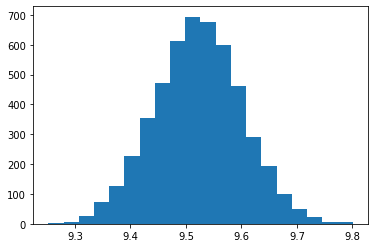

In [87]:
results = bootstrap_prediction(reg, 10)
plt.hist(results, bins=20)

In [88]:
import math
pd.options.mode.chained_assignment = None 
train_df[['y_hat']] = reg.predict(train_df[['g_x']])
#Testing the coefficient of determination in the training set. R^2 is the proportion
#of the variance in the dependent variable that is predictable from the independent variables
r_squared = reg.score(train_df[['g_y']], train_df[['y_hat']])
#Mean Squared Error is used to compare between different models where the smaller the number the better
#An unbiased esitmator with the smallest variance among all unbiased estimators is the best unbiased
#estimator or MVUE(minimum Variance Unbiased Estimator)
mse = mean_squared_error(train_df[['g_y']], train_df[['y_hat']])
print(("Baseline linear model train set metrics:\n"
       f"R^2 for train set: {round(r_squared, 4)}\n"
       f"Mean Squared Error for train set: {round(mse, 4)}\n"
       f"Root Mean Squared Error for train set: {math.sqrt(round(mse, 2))}"))

Baseline linear model train set metrics:
R^2 for train set: 0.5009
Mean Squared Error for train set: 35.5194
Root Mean Squared Error for train set: 5.959865770300536


In [46]:
#Now start building a new linear model that takes into affect new features and maybe use 
#ridge or lasso for feature selection


In [ ]:
#write a funciton to determine the pareto division of how much of the fat tail is held by what 
#percentage of players

In [216]:
#pareto distribution function
import math
alpha = 1/(1-(math.log10(.7)/math.log10(0.3)))
x_sub_m = 1
def pareto_prob(x):
    """
    returns probability that some number X will be greater than x by the distribution of the Pareto curve
    defined by observed goal scoring behavior
    """
    alpha = 1/(1-(math.log10(.7)/math.log10(0.3)))
    x_sub_m = 1
    return (x_sub_m/x)^alpha